Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

In [ ]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

In [ ]:
import json
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
import copy
from collections import deque

from IPython import display as ipythondisplay
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [ ]:
!pip install gym[box2d]

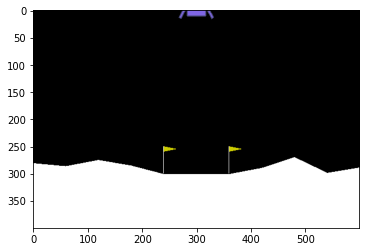

In [ ]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))

In [ ]:
state_size = env.observation_space
print("state size is:", state_size)
a = env.action_space
print("action size=", a)
state = env.reset()
print(state)

state size is: Box(-inf, inf, (8,), float32)
action size= Box(-1.0, 1.0, (2,), float32)
[ 0.00727329  1.4221375   0.7367081   0.4985361  -0.00842132 -0.16687548
  0.          0.        ]


# Action Space
            #is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

# Action Space (continuous to discrete values)

In [ ]:
class ActionSpace(object):
    def __init__(self, x_size, y_size):
        self.x_size = x_size
        self.y_size = y_size
        self.cache = {}
        self.build_actions_cache()

    def build_actions_cache(self):
        for i in range(self.x_size * self.y_size):
            self.cache[i] = self.get_value_by_key(i)

    def get_value_by_key(self, key):
        ind1 = int(key / self.y_size)
        ind2 = key % self.y_size
        value1 = 0 + ind1 * (1 / (self.x_size - 1))

        if ind1 == 0:
            value1 = -1
        if ind2 == 0:
            value2 = 0
        else:
            half = (self.y_size - 1) / 2
            if ind2 <= self.y_size/2:
                value2 = -0.5+- ind2 * (0.5 / (half))
            else:
                ind2 = ind2 - half
                value2 = 0.5 + ind2 * (0.5 / (half))

        return [value1, value2]

    def choose(self, key):
        return self.cache[key]


x_actions = 2
y_actions = 15  # y_actions must be an odd number.
all_actions = x_actions * y_actions
action_space = ActionSpace(x_actions, y_actions)

# DQN Model.

In [ ]:
class DoubleDQN(nn.Module):
    def __init__(self, all_actions):
        super(DoubleDQN, self).__init__()

        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, all_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

# GPU/CPU

In [ ]:
device = None
if torch.cuda.is_available():
    print("Using GPU.")
    device = torch.device('cuda:0')
else:
    print("Using CPU.")
    device = torch.device("cpu")

Using GPU.


# Replay Memory

In [ ]:
class ReplayMemory(object):
    def __init__(self, replay_memory_size):
        self.memory = deque(maxlen=replay_memory_size)

    def size(self):
        return len(self.memory)

    def push(self, state, action, reward, observation, done):
        self.memory.append((state, action, reward, observation, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# Methods

In [ ]:
def choose_action(state, epsilon, model):
    model.eval()
    if np.random.rand() <= epsilon:
        return np.random.choice(all_actions)
    else:
        unsqueeze = state.unsqueeze(0)
        preds = model(unsqueeze)
        value, indice = torch.max(preds, 1)
        return indice[0].item()


def run_replay_experiments(model, target_model, replay_memory, optimizer, batch_size):
    optimizer.zero_grad()
    model.eval()
    target_model.eval()

    x_batch = []
    x_target = []
    samples_batch = replay_memory.sample(batch_size)

    for state, action, reward, observation, done in samples_batch:
        x_batch.append(state)
        x_target.append(observation)

    x_batch = torch.stack(x_batch).to(device)
    x_target = torch.stack(x_target).to(device)

    model_target_preds = model(x_target)
    target_preds = target_model(x_target)
    _, indices = torch.max(model_target_preds, 1)

    max_values = []
    for i in range(len(indices)):
        max_values.append(target_preds[i][indices[i]])
    model.train()

    model_preds = model(x_batch)
    model_preds_clone = model_preds.clone()

    for index, (state, action, reward, observation, done) in enumerate(samples_batch):
        if done:
            model_preds_clone[index][action] = reward
        else:
            model_preds_clone[index][action] = reward + gama * max_values[index]

    loss = F.smooth_l1_loss(model_preds, model_preds_clone)
    loss.backward()
    optimizer.step()

# Parameters.

In [ ]:
epsilon = 1
epsilon_decay = 0.975

batch_size = 256
max_iterations = 50000

reset_target = 200
steps_per_action = 1
replay_memory_size = 20000

gama = 0.99
lr = 0.00005

# Training the model.

In [ ]:
env = wrap_env(env)


model = DoubleDQN(all_actions)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

if not next(model.parameters()).is_cuda:
    print('The neural network model is not working on GPU!')

average100 = deque(maxlen=100)
replay_memory = ReplayMemory(replay_memory_size)

results_memory = []
steps=0
for iteration in range(max_iterations):
    state = env.reset()
    total_reward = 0
    done = False
    state = torch.from_numpy(state).to(device)

    while not done:
        action = choose_action(state, epsilon, model)
        converted_action = action_space.choose(action)

        observation, reward, done, _ = env.step(converted_action)
        observation = torch.from_numpy(observation).to(device)
        total_reward += reward

        replay_memory.push(state, action, reward, observation, done)
        state = observation


        for i in range(steps_per_action):
            if steps % reset_target == 0:
                target_model = copy.deepcopy(model)
                target_model.to(device)  
            steps=steps+1        
            if replay_memory.size() >= batch_size:
                run_replay_experiments(model, target_model, replay_memory, optimizer, batch_size)


    average100.append(total_reward)
    epsilon *= epsilon_decay
    print(f'Iteration: {iteration} | Epsilon: {round(epsilon, 2)} | Last Reward: {round(reward, 2)} | Average100: {round(np.average(average100))} | Total Reward: {total_reward}')
    results_memory.append((iteration, round(np.average(average100))))

    if len(average100) >= 100 and np.average(average100) >= 200:
        print(f'Finished after {iteration-100} iterations.')
        break

Iteration: 0 | Epsilon: 0.97 | Last Reward: -100 | Average100: -374 | Total Reward: -374.02281568070106
Iteration: 1 | Epsilon: 0.95 | Last Reward: -100 | Average100: -311 | Total Reward: -247.26800826790983
Iteration: 2 | Epsilon: 0.93 | Last Reward: -100 | Average100: -321 | Total Reward: -342.3024826035188
Iteration: 3 | Epsilon: 0.9 | Last Reward: -100 | Average100: -405 | Total Reward: -658.3988486649622
Iteration: 4 | Epsilon: 0.88 | Last Reward: -100 | Average100: -372 | Total Reward: -237.56775873937707
Iteration: 5 | Epsilon: 0.86 | Last Reward: -100 | Average100: -402 | Total Reward: -549.5507485445402
Iteration: 6 | Epsilon: 0.84 | Last Reward: -100 | Average100: -387 | Total Reward: -298.58092294882044
Iteration: 7 | Epsilon: 0.82 | Last Reward: -100 | Average100: -347 | Total Reward: -67.4595637965728
Iteration: 8 | Epsilon: 0.8 | Last Reward: -100 | Average100: -356 | Total Reward: -428.24544904347164
Iteration: 9 | Epsilon: 0.78 | Last Reward: -100 | Average100: -349 | T

In [ ]:
# Memory to JSON data.
with open('/content/gdrive/My Drive/Double DQN.json', 'w') as f:
    json.dump(results_memory, f)

In [ ]:
# Upload JSON data to notebook.
loaded_results_memory = None
with open('/content/gdrive/My Drive/Double DQN.json') as f:
    loaded_results_memory = json.loads(f.read())

print(loaded_results_memory[0])

[0, -374]


In [ ]:
env.close() 
show_video()